In [190]:
import pandas as pd
from phik import phik_matrix

df = pd.read_csv(filepath_or_buffer='hotel_bookings_cleaned.csv')

---

# **Data Preprocessing**

## Correlation

In [185]:
unused_columns = ['total_stays_in_nights', 'total_guests', 'revenue']

# Computing pairwise correlation of numerical variables
df.drop(columns=unused_columns)\
      .corr(method='spearman', # Using Spearman's method for non-parametric variables
            numeric_only=True)\
      .style.background_gradient(cmap=None).format(formatter='{:.3f}') # Adding colors & rounding numbers displayed

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
is_canceled,1.000,0.225,0.087,-0.000,0.005,0.059,0.095,0.089,0.061,-0.021,-0.090,0.126,-0.101,-0.125,0.015,0.141,-0.186,-0.129
lead_time,0.225,1.000,0.136,0.097,0.012,0.292,0.415,0.228,0.050,-0.002,-0.220,0.000,-0.191,0.056,0.098,0.101,-0.110,0.061
arrival_date_year,0.087,0.136,1.000,-0.516,-0.011,0.009,0.018,0.058,0.043,-0.023,0.023,-0.109,0.033,-0.005,-0.029,0.189,-0.041,0.066
arrival_date_week_number,-0.000,0.097,-0.516,1.000,0.088,0.036,0.041,0.025,0.017,0.017,-0.039,0.047,-0.047,0.018,-0.000,0.114,0.010,0.044
arrival_date_day_of_month,0.005,0.012,-0.011,0.088,1.000,-0.009,-0.017,0.003,0.017,0.000,-0.004,-0.004,-0.001,0.005,0.012,0.019,0.008,-0.003
stays_in_weekend_nights,0.059,0.292,0.009,0.036,-0.009,1.000,0.326,0.128,0.035,0.018,-0.121,-0.028,-0.108,0.021,-0.039,0.044,-0.044,0.035
stays_in_week_nights,0.095,0.415,0.018,0.041,-0.017,0.326,1.000,0.170,0.045,0.024,-0.150,-0.031,-0.135,0.051,0.006,0.081,-0.051,0.054
adults,0.089,0.228,0.058,0.025,0.003,0.128,0.170,1.000,0.068,0.027,-0.219,-0.087,-0.238,-0.075,-0.034,0.335,0.013,0.157
children,0.061,0.050,0.043,0.017,0.017,0.035,0.045,0.068,1.000,0.032,-0.049,-0.030,-0.050,0.047,-0.029,0.284,0.041,0.055
babies,-0.021,-0.002,-0.023,0.017,0.000,0.018,0.024,0.027,0.032,1.000,-0.014,-0.007,-0.016,0.117,-0.007,0.021,0.033,0.092


Notes:
* If there are no repeated/duplicated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone (linear) function of the other. If Y variable tends to increase when X variable increases, the Spearman correlation coefficient is positive —and vice versa for negative coefficient.
* Pairing of variables with moderate to high positive correlation value (0.33 - 1) are:
    * `is_repeated_guest` & `previous_bookings_not_canceled`
    * `previous_cancellations` & `previous_bookings_not_canceled`

Correlated variables provide redundant information and reducing prediction model's ability to generalize (causing overfitting). Therefore, **variable which causes this correlation will not be used: `previous_bookings_not_canceled`**.

* adults - adr = 0.34  
    * moderately correlated?  
    * which one to drop? adr?
    * total_guests = medium - high correlation with others
* arrival_date_week_number = drop
* lead_time - stays_in_week_nights?
    * total_stays = also medium - high?

In [186]:
# Selecting categorical variables as subset
categorical_target_vars = df.select_dtypes(include='object')\
                            .combine_first(other=df[['is_canceled']]) # Combining subset with target variable

# Computing pairwise correlation of categorical & target variables
phik_matrix(df=categorical_target_vars, 
            # Applying target as interval column/variable
            interval_cols='is_canceled')\
            .style.background_gradient(cmap=None).format(formatter='{:.3f}')

,arrival_date_month,assigned_room_type,country,customer_type,deposit_type,distribution_channel,hotel,is_canceled,market_segment,meal,reservation_status,reservation_status_date,reserved_room_type
arrival_date_month,1.000,0.095,0.262,0.213,0.114,0.125,0.076,0.108,0.168,0.147,0.151,0.977,0.110
assigned_room_type,0.095,1.000,0.139,0.175,0.135,0.146,0.477,0.120,0.171,0.346,0.148,0.219,0.940
country,0.262,0.139,1.000,0.230,0.226,0.316,0.445,0.235,0.401,0.232,0.322,0.505,0.163
customer_type,0.213,0.175,0.230,1.000,0.053,0.111,0.094,0.193,0.453,0.194,0.097,0.493,0.152
deposit_type,0.114,0.135,0.226,0.053,1.000,0.049,0.034,0.100,0.304,0.034,0.342,0.581,0.081
distribution_channel,0.125,0.146,0.316,0.111,0.049,1.000,0.111,0.123,0.772,0.115,0.147,0.333,0.224
hotel,0.076,0.477,0.445,0.094,0.034,0.111,1.000,0.108,0.164,0.467,0.043,0.260,0.408
is_canceled,0.108,0.120,0.235,0.193,0.100,0.123,0.108,1.000,0.206,0.082,1.000,0.367,0.072
market_segment,0.168,0.171,0.401,0.453,0.304,0.772,0.164,0.206,1.000,0.231,0.234,0.477,0.210
meal,0.147,0.346,0.232,0.194,0.034,0.115,0.467,0.082,0.231,1.000,0.043,0.321,0.253


Notes:
* Phi_K (ϕk) library is used to compute correlation between categorical and interval variables.
    * Based on Pearson's chi-squared contingency test —a hypothesis test for independence between two or more variables.
    * `is_canceled` is added into this analysis because we would want to find the association between categorical variables and the target of this prediction model, and also applied as interval variable because the difference between values in this column (`1` or `0`) is meaningful.
    * Phi_K correlation matrix drops missing value from the data to calculate the correlation coefficient by default (parameter `dropna` already set to `True`).
    * It captures any non-linear relationship between variables, and has a built-in noise reduction against statistical fluctuations or outliers (parameter `noise_correction` also set to `True` by default).
    * Correlation coefficient value is between 0 and 1, hence no indication of relationship direction between variables.
* There are plenty of variable pairings with moderate to high correlation value (ϕk value of 0.33 - 1).
    * First step of this analysis segment will drop correlated variables with target `is_canceled`:
        * `reservation_status` (ϕk = `1.000`; perfectly correlated)
        * `reservation_status_date` (ϕk = `0.367`; medium correlation)

In [26]:
# Dropping variables correlated with target
categorical_target_vars.drop(columns=['reservation_status', 'reservation_status_date'], inplace=True)

# Verifying process
phik_matrix(df=categorical_target_vars, interval_cols='is_canceled').style.background_gradient(cmap=None).format(formatter='{:.3f}')

,arrival_date_month,assigned_room_type,country,customer_type,deposit_type,distribution_channel,hotel,is_canceled,market_segment,meal,reserved_room_type
arrival_date_month,1.000,0.095,0.262,0.213,0.114,0.125,0.076,0.108,0.168,0.147,0.110
assigned_room_type,0.095,1.000,0.139,0.175,0.135,0.146,0.477,0.120,0.171,0.346,0.940
country,0.262,0.139,1.000,0.230,0.226,0.316,0.445,0.235,0.401,0.232,0.163
customer_type,0.213,0.175,0.230,1.000,0.053,0.111,0.094,0.193,0.453,0.194,0.152
deposit_type,0.114,0.135,0.226,0.053,1.000,0.049,0.034,0.100,0.304,0.034,0.081
distribution_channel,0.125,0.146,0.316,0.111,0.049,1.000,0.111,0.123,0.772,0.115,0.224
hotel,0.076,0.477,0.445,0.094,0.034,0.111,1.000,0.108,0.164,0.467,0.408
is_canceled,0.108,0.120,0.235,0.193,0.100,0.123,0.108,1.000,0.206,0.082,0.072
market_segment,0.168,0.171,0.401,0.453,0.304,0.772,0.164,0.206,1.000,0.231,0.210
meal,0.147,0.346,0.232,0.194,0.034,0.115,0.467,0.082,0.231,1.000,0.253


Notes:
* Number of pairings of variables with moderate-high correlation value are listed below:
    * `hotel`: 4 pairings
    * `assigned_room_type` and `market_segment`: 3 pairings
    * `country`, `meal`, and `reserved_room_type`: 2 pairings
    * `customer_type` and `distribution_channel`: 1 pairing
* To reduce this number, the second step of this segment will iterate to drop these variables, starting from the top (highest number of pairings).

In [27]:
# Dropping top 3 variables with the highest amount of correlation pairings
categorical_target_vars.drop(columns=['hotel', 'assigned_room_type', 'market_segment'], inplace=True)

# Verifying process
phik_matrix(df=categorical_target_vars, interval_cols='is_canceled').style.background_gradient(cmap=None).format(formatter='{:.3f}')

,arrival_date_month,country,customer_type,deposit_type,distribution_channel,is_canceled,meal,reserved_room_type
arrival_date_month,1.000,0.262,0.213,0.114,0.125,0.108,0.147,0.110
country,0.262,1.000,0.230,0.226,0.316,0.235,0.232,0.163
customer_type,0.213,0.230,1.000,0.053,0.111,0.193,0.194,0.152
deposit_type,0.114,0.226,0.053,1.000,0.049,0.100,0.034,0.081
distribution_channel,0.125,0.316,0.111,0.049,1.000,0.123,0.115,0.224
is_canceled,0.108,0.235,0.193,0.100,0.123,1.000,0.082,0.072
meal,0.147,0.232,0.194,0.034,0.115,0.082,1.000,0.253
reserved_room_type,0.110,0.163,0.152,0.081,0.224,0.072,0.253,1.000


Notes:

* Experimenting to drop only `hotel` still leaves `assigned_room_type` and `market_segment` as variable pairings with moderate-high correlation value.
    * After dropping `assigned_room_type`, and `market_segment`, no more variable pairing with medium-high correlation value detected.
* These categorical variables (excluding `is_canceled`) will be the features used in prediction modeling.

## Outlier

In [28]:
# Defining function for detecting outlier
def detect_outlier(variable):
    Q1, Q3 = df[variable].quantile(q=0.25), df[variable].quantile(q=0.75)
    IQR = Q3 - Q1
    lower_boundary, upper_boundary = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    outliers = df.loc[(df[variable] <  (lower_boundary)) | (df[variable] > (upper_boundary))]
    return outliers

Notes:

* Outlier detection uses adjusted box-plot method:
    * Used for data with non-normal (skewed) distribution.
    * Q1 and Q3 are defined as 25th and 75th percentile of the data, respectively.
    * Interquartile range (IQR) as the distance between Q1 and Q3.
    * Boundaries for this method are defined as 1.5 of IQR for both side, and
    * Data points outside these boundaries are flagged as outliers.

In [29]:
numeric_vars = df.select_dtypes(include='number')

# Showing summary of outlier in numerical variables
pd.DataFrame(data={'numeric_variables': numeric_vars.columns,
                   'n': [detect_outlier(var).shape[0] for var in numeric_vars],
                   '%': [round(number=detect_outlier(var).shape[0] / df.shape[0] * 100, ndigits=2) for var in numeric_vars],
                   'sample': [sorted(detect_outlier(var)[var].unique()) for var in numeric_vars],
                   'min': [detect_outlier(var)[var].min() for var in numeric_vars],
                   'max': [detect_outlier(var)[var].max() for var in numeric_vars]})

,numeric_variables,n,%,sample,min,max
0,is_canceled,0,0.00,[],NaN,NaN
1,lead_time,2470,2.84,"[295, 296, 297, 298, 299, 300, 301, 302, 303, ...",295.00,737.0
2,arrival_date_year,0,0.00,[],NaN,NaN
3,arrival_date_week_number,0,0.00,[],NaN,NaN
4,arrival_date_day_of_month,0,0.00,[],NaN,NaN
5,stays_in_weekend_nights,218,0.25,"[6, 7, 8, 9, 10, 12, 13, 14, 16]",6.00,16.0
6,stays_in_week_nights,1522,1.75,"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20...",9.00,41.0
7,total_stays_in_nights,3001,3.45,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...",10.00,57.0
8,adults,22600,25.99,"[0, 1, 3, 4, 5, 6, 10, 20, 26, 27, 40, 50, 55]",0.00,55.0
9,children,8353,9.61,"[1, 2, 3, 10]",1.00,10.0


Notes:

* Depending on the context, outliers either (1) deserve special attention or (2) should be completely ignored. 
    1. Take an example of `lead_time`: if unusual number of days are observed, it may be a good idea to pay extra attention to them and figure out whether these values are sensible or not (based on the data description). So in instances like these, it is useful to investigate the outlier values and handling them accordingly.
    2. If outliers are however, introduced due to mechanical error, measurement error or anything else that cannot be generalized, it is a good idea to remove these outliers before feeding the data to the modeling algorithm —because some algorithms are sensitive to outliers.
* Tree-based algorithms are almost the only algorithms that are not affected by the magnitude of the input, as we can easily see from how trees are built.  When deciding how to make a split, tree algorithm look for decisions like "whether feature value X > a certain value" and compute the purity of the child node after the split, so the scale of the feature does not count.

| Variable | Insights |
| --- | --- |
| lead_time | customer bisa aja booking dari jauh hari; misal booking pada tahun x untuk menginap tahun x + 2 sehingga `lead_time` = ~730 |
| stays_in_weekend_nights | customer bisa aja booking untuk menginap selama 19 hari weekend |
| stays_in_week_nights | customer bisa aja booking untuk menginap selama 50 hari weekday |
| adults | customer bisa memesan untuk rombongan yang tidak berisi orang dewasa (`adults` = 0)? |
| | customer bisa aja memesan untuk rombongan yang berisi 55 orang dewasa |
| children | customer bisa aja memesan untuk rombongan yang berisi 10 orang remaja |
| babies | customer bisa aja memesan untuk rombongan yang berisi 10 orang anak-anak |
| previous_cancellations | customer bisa aja memiliki riwayat pembatalan booking hingga 26x |
| previous_bookings_not_canceled | menandakan bahwa customer adalah pelanggan yang rutin booking Hotel (hingga memiliki riwayat 72x booking) |
| booking_changes | customer bisa aja memiliki riwayat mengubah spesifikasi di dalam booking hingga 21x, bahkan hingga booking tersebut dibatalkan |
| days_in_waiting_list | customer bisa menunggu hingga ~365 hari (1 tahun) hingga pemesanannya disetujui oleh pihak hotel? |
| adr | menandakan bahwa pendapatan harian hotel bisa berfluktuatif hingga 5.400 satuan moneter per hari |
| required_car_parking_spaces | customer bisa aja memesan untuk rombongan yang membutuhkan 8 tempat parkir |
| total_of_special_requests | customer bisa aja memiliki 5 permintaan khusus dalam pemesanannya |

Notes:

* `previous_cancellations` tinggi (outlier) belum tentu `is_canceled`, karena nilai median dari bivariat `previous_cancellations` dengan `is_canceled` adalah 0
    * begitu pula dengan `previous_bookings_not_canceled`, tapi kolom ini redundant & di drop
    * begitu pula dengan `booking_changes`
    * begitu pula dengan `days_in_waiting_list`?
* There are several options to handle outlier, namely:
    * Scaling
        * When the distribution of the variable is skewed, it is better to scale using the median and quantiles method, which is more robust to outliers.
    * Transformation
        * Since this analysis is in the context of a business setting, it is better to use the original variable without transformation to train the model, as this would represent a simpler situation at the time of asking developers to implement the model in real life, and also it will be easier to interpret.
    * Binning
        * Equal frequency binning is straightforward to implement, and by spreading the values of the observations more evenly, it may help boost the model's performance. On the other hand, arbitrary binning (including equal width binning) may also disrupt the relationship with the target on occasion.
        * When engineering variables in a business setting, the business experts determine the intervals in which they think the variable should be divided so that it makes sense for the business. These intervals may be defined both arbitrarily or following some criteria of use to the business. Typical variables to be applied using this domain knowledge discretization are Age and Income. 
        * Therefore, whenever possible, it will bring value to examine whether such type of binning is the right strategy, and it will depend on the variable and the model that will be used to make the prediction.

## Cardinality

In [30]:
# Listing categorical variables
categorical_vars = df.select_dtypes(include='object')

# Showing summary of cardinality in categorical variables
pd.DataFrame(data={'categorical_columns': categorical_vars.columns,
                   'unique (n)': categorical_vars.nunique(dropna=False).values,
                   'unique_sample': [df[var].unique() for var in categorical_vars],
                   'rare_label (n)': [sum(df[var].value_counts(normalize=True, dropna=False) < 0.05) for var in categorical_vars],
                   'rare_label_sample': [df[df[var].map(arg=df[var].value_counts(normalize=True, dropna=False) < 0.05)][var].unique() 
                                         for var in categorical_vars]})

,categorical_columns,unique (n),unique_sample,rare_label (n),rare_label_sample
0,hotel,2,"[Resort Hotel, City Hotel]",0,[]
1,arrival_date_month,12,"[July, August, September, October, November, D...",0,[]
2,meal,4,"[BB, FB, HB, SC]",1,[FB]
3,country,177,"[PRT, GBR, USA, ESP, IRL, FRA, ROU, NOR, OMN, ...",172,"[USA, IRL, ROU, NOR, OMN, ARG, POL, BEL, CHE, ..."
4,market_segment,7,"[Direct, Corporate, Online TA, Offline TA/TO, ...",3,"[Corporate, Complementary, Aviation]"
5,distribution_channel,5,"[Direct, Corporate, TA/TO, Undefined, GDS]",2,"[Undefined, GDS]"
6,reserved_room_type,10,"[C, A, D, E, G, F, H, L, B, P]",7,"[C, G, F, H, L, B, P]"
7,assigned_room_type,12,"[C, A, D, E, G, F, I, B, H, L, K, P]",9,"[C, G, F, I, B, H, L, K, P]"
8,deposit_type,3,"[No Deposit, Refundable, Non Refund]",2,"[Refundable, Non Refund]"
9,customer_type,4,"[Transient, Contract, Transient-Party, Group]",2,"[Contract, Group]"


Notes:

* The number of different (unique) labels within a categorical variable is known as cardinality. A high number of labels within a variable is known as high cardinality.
    * Also different categories appear in the dataset with different frequencies. Some labels appear a lot in the dataset, whereas some other labels appear only in a few number of observations —hence called rare labels.
* High cardinality & rare values may pose the following problems:
    * A big number of labels (whether frequent or infrequent) within a variable may introduce noise with little, if any, information, therefore making machine learning model prone to over-fit.
    * Some of the labels may only be present in the training data set, but not in the test set, therefore machine learning algorithm may over-fit to the training set.
    * Contrarily, some labels may appear only in the test set, therefore leaving the machine learning algorithm unable to perform a calculation over the new (unseen) observation —a case of model underfit.
    * In particular, tree-based model can be biased towards variable with lots of labels. Thus, their performance may be affected by high cardinality.
    * Sometimes rare values are indeed important. If we are building a model to predict hotel booking cancellation, which are —by nature— rare compared to successful booking, then a rare value in a certain variable may be very predictive. This rare value could be telling us that the observation is most likely a cancelled booking, and it would be best not to ignore it.
* High number of cardinality in dataset are detected in `country`, `agent`, `company`, and `reservation_status_date` (relative to other variables), while rare labels are found in all variables except `hotel` and `arrival_date_month`
* solution: 
    1. reduce by recategorize, either all categories or only specific labels deemed rare
    2. use the labels as-is (without any modifications)


* `lead_time` binning 1 bulan, 2-12 bulan, > 12 bulan
* `stays_in_nights` berarti checkout malam; bisa aja guest checkout siang sehingga `stays_in_nights` = 0
* `adult` + `children` + `babies` = `total_guest`
    * `total_guest` = 0 maka missing value & drop
* lengkapi EDA

---

# Modeling

In [205]:
# Importing libraries for prediction modeling
from sklearn.model_selection import train_test_split
from pycaret.internal.preprocess.transformers import TransformerWrapper
from category_encoders import OrdinalEncoder, BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from pycaret.classification import *
import numpy as np
from sklearn.metrics import fbeta_score
from feature_engine.encoding import RareLabelEncoder

In [32]:
# Setting arbitrary number to 'random_state'
random_state_ = 1

# Splitting dataset into dataframes for training and testing
df_train, df_test = train_test_split(df, random_state=random_state_, stratify=df.is_canceled)

# Showing dataframes' summary
display(pd.DataFrame(data={'dataset': ['df_train', 'df_test'],
                   'row (n)': [df_train.shape[0], df_test.shape[0]],
                   'row (%)': [df_train.shape[0] / df.shape[0] * 100, df_test.shape[0] / df.shape[0] * 100],
                   'column (n)': [df_train.shape[1], df_test.shape[1]]}))

display(pd.DataFrame(data={'df_train': round(number=df_train.is_canceled.value_counts(normalize=True) * 100, ndigits=3),
                   'df_test': round(number=df_test.is_canceled.value_counts(normalize=True) * 100, ndigits=3)}).T)

,dataset,row (n),row (%),column (n)
0,df_train,65205,75.0,33
1,df_test,21735,25.0,33


,0,1
df_train,72.410,27.590
df_test,72.409,27.591


Notes:
* Splitting is done to partition dataset into:
    * Training set (`df_train`), which is used to train the machine learning model. This is the core dataset where the model learns to understand patterns and relationship in the data.
    * Test set (`df_test`), which provides a basis for evaluating the model's performance on unseen data.
        * Even though `df_test` originally comes from the same `df` dataset, this set is not used in training the model, and its target (`is_canceled`) will be hidden in the later stage of this modeling section.
        * This dataset is crucial for assessing the model's ability to generalize into unknown data.
* `random_state` is required to control the random sampling process applied to dataset before splitting into `df_train` and `df_test` —including data for validation, which will be implemented later on.
    * This is done so that the result of splitting (rows, columns, and all their values/data points/observations) will be identical for each time the programming code in this modeling section is called.
* By applying `stratify` parameter, the dataset is sampled in a stratified fashion, to ensure that relative class/target `is_canceled` frequencies is approximately preserved in each train and validation fold.
    * tapi masih imbalance...

In [337]:
# Creating custom pipeline for modeling
pipeline = [
    ('ordinal', TransformerWrapper(
        transformer=OrdinalEncoder(mapping=[{'col': 'meal', 
                                             'mapping': {'SC': 0, 
                                                         'BB': 1, 
                                                         'HB': 2, 
                                                         'FB': 3}}]))),
    ('binary', TransformerWrapper(
        include=['country'], 
        transformer=BinaryEncoder())),
    ('onehot', TransformerWrapper(
        include=['arrival_date_month', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type'], 
        transformer=OneHotEncoder(handle_unknown='ignore')))]

Notes:

* `meal` encoded with `OrdinalEncoder` because categories in this variable can be meaningfully ordered from the type of Hotel meal booked: ` SC < BB < HB < FB`.
* Several categorical variables are encoded with `OneHotEncoder`:
    * `distribution_channel`, `reserved_room_type`, `deposit_type`, and `customer_type`, because these columns contain a small amount of cardinality.
    * Encoding/replacing these variables to boolean variables of 1 and 0 would still relatively increase the feature space (number of variables used in model training), but not to a large degree.
    * `handle_unknown` parameter applied to `ignore` unknown categories found in the encoding process.
        * After splitting the dataset, certain categories may be found in `df_train` but not in `df_test`, for example.
        * By using this parameter, categories only encountered in `df_test` will all be encoded to zeros.
* `country` encoded with `BinaryEncoder` because, without any modifications to its original categories, this variable contains a large amount of cardinality
    * Encoding this variable with `OneHotEncoder` would result in a large feature space, and further slowing down the training time of the model
    * `BinaryEncoder` is appropriate to use in this situation; this encoding scheme uses binary value to split a categorical feature into several columns
        * In the case of `country`, 177 categories in this variable will be converted to its binary value of 10110001 —a value with 8 digits. This binary is then used to split this variable into 8 columns.
        * Each categories in this variable will be converted to numerical (using ordinal encoding scheme) and then transformed to binary value. Each binary value would then be plotted accordingly to these 8 columns.

## Model Experimentation

### Experiment #0: Basic Model

In [338]:
# Defining keyword arguments for PyCaret setup
kwargs = {
    'data': df_train,
    'target': 'is_canceled',
    'preprocess': False, # Disabling PyCaret's in-built preprocessing pipeline
    'session_id': random_state_, # Using defined random state for train-validation splitting
    'ignore_features': ['hotel', 'arrival_date_week_number', 'total_stays_in_nights', 'total_guests', 'market_segment', 'previous_bookings_not_canceled', 
                        'assigned_room_type', 'agent', 'company', 'revenue', 'reservation_status', 'reservation_status_date']}

# Initializing model training environment
experiment0 = setup(**kwargs, 
                     custom_pipeline=pipeline) # Implementing custom pipeline

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 33)"
4,Transformed data shape,"(65205, 58)"
5,Transformed train set shape,"(45643, 58)"
6,Transformed test set shape,"(19562, 58)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


Notes:

* ignore features berasal dari...
* pycaret pakai default stratifiedshufflesplit untuk crossval
* test set = validation set

In [35]:
# Validating usage of custom pipeline
experiment0.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposit_type',
                                                                                                    'customer_type'],
                                                                                              dr...
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['arrival_date_month',
                                                                            'distribution_channel',
                                                                            'reserved_room_type',
                                                                            'deposit_type',
                                                                            'customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop=None,
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='ignore',
                                                                                             max_categories=None,
                                                                                             min_frequency=None,
                                                                                             sparse='deprecated',
                                                                                             sparse_output=True))))],
         verbose=False)

In [255]:
# Validating feature transformation using custom pipeline
X_train_transformed0 = experiment0.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed0)

,lead_time,arrival_date_year,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
57405,3,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19,1,3,1,0,0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,110.000000,0,0
20559,172,2016,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,5,2,1,1,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,155.649994,1,2
48057,169,2017,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,2,3,2,1,0,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,117.000000,0,1
24493,92,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,0,4,2,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,1.0,37.799999,0,0
30547,15,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30,0,4,2,0,0,1,0,0,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,84.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33952,0,2015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2,0,0,0,0,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.000000,0,0
50538,199,2017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6,2,3,2,0,0,0,0,0,0,0,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,89.099998,0,1
71420,182,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,31,1,3,0,2,0,1,0,0,0,0,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,83.500000,0,1
74739,2,2017,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,88.000000,0,0


Notes:

* Setelah kita berhasil mentransformasi data *train*, berikutnya dapat digunakan untuk pemodelan regresi.  
* PyCaret menyediakan kumpulan (*library*) model yang dapat diakses dengan fungsi `compare_models()`, sehingga kita bisa membandingkan performa serangkaian model dan memilih beberapa *estimator* saja sebagai *benchmark* untuk tahapan pemodelan berikutnya.

In [339]:
# Defining Hotel Cost per class prediction error
false_negative = 175
false_positive = (225 + 375) / 2

# Defining function to calculate Hotel Cost
def calculate_cost(y, y_pred):
    FN = np.where((y_pred == 0) & (y == 1), false_negative, 0)
    FP = np.where((y_pred == 1) & (y == 0), false_positive, 0)
    return np.sum(a=[FN, FP])

# Adding 'F-beta' score & Hotel Cost metric
experiment0.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment0.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performance of models available in PyCaret
holdout_experiment0 = experiment0.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8258,0.8813,0.5755,0.7359,0.6458,0.5326,0.5398,0.6970,171645.0000,22.8490
rf,Random Forest Classifier,0.8233,0.8742,0.5442,0.7469,0.6296,0.5173,0.5285,0.6951,170200.0000,6.4090
xgboost,Extreme Gradient Boosting,0.8221,0.8777,0.5783,0.7219,0.6421,0.5257,0.5315,0.6877,177195.0000,7.7770
lightgbm,Light Gradient Boosting Machine,0.8206,0.8754,0.5530,0.7317,0.6298,0.5144,0.5233,0.6872,175277.5000,0.9560
et,Extra Trees Classifier,0.8133,0.8578,0.5316,0.7186,0.6111,0.4918,0.5015,0.6713,181965.0000,8.0380
gbc,Gradient Boosting Classifier,0.7958,0.8400,0.4206,0.7236,0.5319,0.4128,0.4377,0.6324,188460.0000,6.9630
ada,Ada Boost Classifier,0.7792,0.8128,0.4108,0.6607,0.5065,0.3741,0.3917,0.5889,209590.0000,2.6440
lr,Logistic Regression,0.7696,0.7864,0.3460,0.6566,0.4529,0.3243,0.3511,0.5563,212590.0000,14.2120
lda,Linear Discriminant Analysis,0.7655,0.7806,0.3002,0.6662,0.4135,0.2925,0.3289,0.5351,210987.5000,1.1000
ridge,Ridge Classifier,0.7622,0.0000,0.2435,0.6977,0.3607,0.2545,0.3080,0.5077,206532.5000,0.3580


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Notes:

* Highlight bug in `Cost`?
* `CatBoost Classifier` higher in F2, but `Random Forest Classifier` higher in Precision and lower Cost metrics

In [38]:
# Assigning 'Random Forest Classifier' as basic model
model_experiment0 = experiment0.create_model(estimator='rf',
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Notes:

* Will be used as benchmark against model from other experimentation, including the metrics

### Experiment #1: Handling Outlier with Scaling

In [293]:
# Adding 'RobustScaler' to custom pipeline
pipeline.append(
    ('robust', TransformerWrapper(
        include=['lead_time', 'arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights',
                 'adults', 'children', 'babies', 'previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'adr', 
                 'required_car_parking_spaces', 'total_of_special_requests'],
        transformer=RobustScaler())))

# Setting experiment #1 training environment
experiment1 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 33)"
4,Transformed data shape,"(65205, 58)"
5,Transformed train set shape,"(45643, 58)"
6,Transformed test set shape,"(19562, 58)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


In [40]:
# Validating usage of custom pipeline
experiment1.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposit_type',
                                                                                                    'customer_type'],
                                                                                              dr...
                                                                            'arrival_date_day_of_month',
                                                                            'stays_in_weekend_nights',
                                                                            'stays_in_week_nights',
                                                                            'adults',
                                                                            'children',
                                                                            'babies',
                                                                            'previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'adr',
                                                                            'required_car_parking_spaces',
                                                                            'total_of_special_requests'],
                                                                   transformer=RobustScaler(copy=True,
                                                                                            quantile_range=(25.0,
                                                                                                            75.0),
                                                                                            unit_variance=False,
                                                                                            with_centering=True,
                                                                                            with_scaling=True))))],
         verbose=False)

In [41]:
# Validating feature transformation using custom pipeline
X_train_transformed1 = experiment1.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed1)

,lead_time,arrival_date_year,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
57405,-0.412281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.200000,0.0,0.333333,-1.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.175705,0.0,0.0
20559,1.070175,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.800000,0.0,1.000000,0.0,1.0,1.0,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.904880,1.0,2.0
48057,1.043860,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.5,0.333333,0.0,1.0,0.0,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.287517,0.0,1.0
24493,0.368421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.533333,-0.5,0.666667,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.977558,0.0,0.0
30547,-0.307018,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.933333,-0.5,0.666667,0.0,0.0,0.0,1,0,0,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.239597,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33952,-0.438596,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.466667,0.5,-0.666667,-2.0,0.0,0.0,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.581343,0.0,0.0
50538,1.307018,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.666667,0.5,0.333333,0.0,0.0,0.0,0,0,0,0,0,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.158134,0.0,1.0
71420,1.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.0,0.333333,-2.0,2.0,0.0,1,0,0,0,0,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.247584,0.0,1.0
74739,-0.421053,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,-0.5,-0.333333,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.175705,0.0,0.0


In [43]:
# Adding 'F-beta' score & Hotel Cost metric
experiment1.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment1.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #1
holdout_experiment1 = experiment1.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8258,0.8813,0.5755,0.7359,0.6458,0.5326,0.5398,0.6970,171645.0000,22.0960
rf,Random Forest Classifier,0.8233,0.8742,0.5445,0.7467,0.6297,0.5174,0.5285,0.6950,170250.0000,5.7560
xgboost,Extreme Gradient Boosting,0.8221,0.8777,0.5783,0.7219,0.6421,0.5257,0.5315,0.6877,177195.0000,7.9760
lightgbm,Light Gradient Boosting Machine,0.8205,0.8754,0.5526,0.7315,0.6295,0.5141,0.5230,0.6869,175335.0000,0.8460
et,Extra Trees Classifier,0.8133,0.8578,0.5316,0.7186,0.6111,0.4918,0.5015,0.6713,181965.0000,8.1990
gbc,Gradient Boosting Classifier,0.7958,0.8400,0.4206,0.7236,0.5319,0.4128,0.4377,0.6324,188460.0000,6.9580
ada,Ada Boost Classifier,0.7792,0.8128,0.4108,0.6607,0.5065,0.3741,0.3917,0.5889,209590.0000,2.7490
lr,Logistic Regression,0.7701,0.7885,0.3477,0.6573,0.4546,0.3262,0.3527,0.5577,212175.0000,3.3720
knn,K Neighbors Classifier,0.7694,0.7721,0.5065,0.5969,0.5479,0.3945,0.3969,0.5763,238122.5000,2.7590
lda,Linear Discriminant Analysis,0.7655,0.7806,0.3002,0.6662,0.4135,0.2925,0.3289,0.5351,210987.5000,1.1410


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Notes:

* Similar with experimentation before

In [44]:
# Assigning 'Random Forest Classifier' as experimentation model
model_experiment1 = experiment1.create_model(estimator='rf', 
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [108]:
# Accessing cross-validation score from previous experimentations
experiment0_mean = experiment0.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment0_std = experiment0.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]
experiment1_mean = experiment1.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment1_std = experiment1.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]

# Showing absolute range of cross-validation scores
pd.DataFrame(data=[abs((experiment0_mean - experiment0_std) - (experiment0_mean + experiment0_std)),
                   abs((experiment1_mean - experiment1_std) - (experiment1_mean + experiment1_std))],
             index=['Experiment #0', 'Experiment #1'])

,Prec.,F2,Cost
Experiment #0,0.0326,0.0258,12818.5022
Experiment #1,0.0330,0.0258,12909.1634


Notes:

* measures the absolute range between mean and standard deviation for each metrics in both experimentation
    * no significant difference
    * experiment with the lowest/narrowest range is the better one
* As stated previously, Tree-based algorithm (including Random Forest) tend to ignore the presence of outliers when creating the branches of their trees. Typically, trees make decisions by asking if variable `x` >= a certain value. Therefore, the outlier will fall on each side of the branch, but it will be treated equally than the remaining values, regardless of its magnitude.
* no need to experiment with binning?

### Experiment #2: Handling Cardinality/Rare Label

In [211]:
# ...
pipeline.pop()

# Adding 'RareLabelEncoder' to custom pipeline
pipeline.insert(1, 
    ('rare_label', TransformerWrapper(
        include=['country', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type'],
        transformer=RareLabelEncoder(n_categories=3))))

# Setting experiment #2 training environment
experiment2 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 33)"
4,Transformed data shape,"(65205, 46)"
5,Transformed train set shape,"(45643, 46)"
6,Transformed test set shape,"(19562, 46)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


Notes:

* insert before binary because...
* n_categories...
* Reduced number of column

In [ ]:
# Validating usage of custom pipeline
experiment2.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposit_type',
                                                                                                    'customer_type'],
                                                                                              dr...
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['arrival_date_month',
                                                                            'distribution_channel',
                                                                            'reserved_room_type',
                                                                            'deposit_type',
                                                                            'customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop=None,
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='ignore',
                                                                                             max_categories=None,
                                                                                             min_frequency=None,
                                                                                             sparse='deprecated',
                                                                                             sparse_output=True))))],
         verbose=False)

In [ ]:
# Validating feature transformation using custom pipeline
X_train_transformed2 = experiment2.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed2)

,lead_time,arrival_date_year,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country_0,country_1,country_2,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_Rare,distribution_channel_TA/TO,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_D,reserved_room_type_E,reserved_room_type_Rare,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Rare,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
57405,3,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19,1,3,1,0,0,1,0,0,1,0.0,0.0,0.0,1.0,1,0,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,1.0,0.0,110.000000,0,0
20559,172,2016,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,5,2,1,1,1,0,1,0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0,0.0,1.0,0.0,155.649994,1,2
48057,169,2017,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,2,3,2,1,0,1,0,1,1,0.0,0.0,0.0,1.0,0,0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,1.0,0.0,117.000000,0,1
24493,92,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,0,4,2,0,0,1,0,1,0,0.0,0.0,0.0,1.0,0,0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,37.799999,0,0
30547,15,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30,0,4,2,0,0,1,0,1,0,0.0,0.0,0.0,1.0,0,0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,1.0,0.0,84.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33952,0,2015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2,0,0,0,0,1,0,1,1,0.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.000000,0,0
50538,199,2017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6,2,3,2,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0,0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,1.0,0.0,89.099998,0,1
71420,182,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,31,1,3,0,2,0,1,1,0,0,0.0,0.0,0.0,1.0,0,0,0.0,0.0,0.0,1.0,0,1.0,0.0,0.0,0,0.0,1.0,0.0,83.500000,0,1
74739,2,2017,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,0,1,2,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0,0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,1.0,0.0,88.000000,0,0


Notes:

* Rare...

In [ ]:
# Adding 'F-beta' score & Hotel Cost metric
experiment2.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment2.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #1
holdout_experiment2 = experiment2.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,06:13:12
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8236,0.8807,0.5737,0.7295,0.6422,0.5274,0.5342,0.6919,174400.0000,13.9790
rf,Random Forest Classifier,0.8226,0.8744,0.5515,0.7397,0.6318,0.5182,0.5280,0.6924,172280.0000,5.4900
xgboost,Extreme Gradient Boosting,0.8218,0.8778,0.5826,0.7184,0.6434,0.5263,0.5315,0.6864,178350.0000,5.4290
lightgbm,Light Gradient Boosting Machine,0.8191,0.8755,0.5486,0.7290,0.6260,0.5098,0.5189,0.6839,176600.0000,0.6550
et,Extra Trees Classifier,0.8114,0.8558,0.5422,0.7062,0.6134,0.4915,0.4990,0.6659,186177.5000,6.3240
gbc,Gradient Boosting Classifier,0.8029,0.8497,0.4447,0.7372,0.5546,0.4378,0.4610,0.6513,182407.5000,5.3360
ada,Ada Boost Classifier,0.7869,0.8157,0.4200,0.6858,0.5209,0.3939,0.4135,0.6086,200510.0000,1.9460
lr,Logistic Regression,0.7749,0.7867,0.3573,0.6734,0.4666,0.3407,0.3683,0.5718,207027.5000,9.0230
lda,Linear Discriminant Analysis,0.7693,0.7814,0.2965,0.6909,0.4144,0.2986,0.3401,0.5450,205102.5000,0.7330
ridge,Ridge Classifier,0.7652,0.0000,0.2405,0.7251,0.3607,0.2591,0.3187,0.5159,201930.0000,0.4810


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Notes:

* random forest highest in precision F2, lowest in cost

In [ ]:
# Assigning 'Random Forest Classifier' as experimentation model
model_experiment2 = experiment2.create_model(estimator='rf', 
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# ...
experiment2_mean = experiment2.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment2_std = experiment2.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]

# ...
pd.DataFrame(data=[abs((experiment0_mean - experiment0_std) - (experiment0_mean + experiment0_std)),
                   abs((experiment2_mean - experiment2_std) - (experiment2_mean + experiment2_std))],
             index=['Experiment #0', 'Experiment #2'])

,Prec.,F2,Cost
Experiment #0,0.0326,0.0258,12818.5022
Experiment #2,0.0372,0.0292,14733.4620


Notes:

* cardinality enggak ngefek?

### Experiment #3: Handling Imbalanced Data with Polynomial Features

In [212]:
# ...
pipeline.pop(1)

# Adding '...' to custom pipeline
pipeline.append(
    ('polynomial', TransformerWrapper(
        include=[var for var in numeric_vars.drop(columns=['is_canceled', 'arrival_date_week_number', 'total_stays_in_nights', 
                                                           'total_guests', 'previous_bookings_not_canceled', 'revenue'])],
        transformer=PolynomialFeatures())))

# Setting experiment #2 training environment
experiment3 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 33)"
4,Transformed data shape,"(65205, 179)"
5,Transformed train set shape,"(45643, 179)"
6,Transformed test set shape,"(19562, 179)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


In [213]:
# Validating usage of custom pipeline
experiment3.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposit_type',
                                                                                                    'customer_type'],
                                                                                              dr...
                                                                            'arrival_date_day_of_month',
                                                                            'stays_in_weekend_nights',
                                                                            'stays_in_week_nights',
                                                                            'adults',
                                                                            'children',
                                                                            'babies',
                                                                            'is_repeated_guest',
                                                                            'previous_cancellations',
                                                                            'booking_changes',
                                                                            'days_in_waiting_list',
                                                                            'adr',
                                                                            'required_car_parking_spaces',
                                                                            'total_of_special_requests'],
                                                                   transformer=PolynomialFeatures(degree=2,
                                                                                                  include_bias=True,
                                                                                                  interaction_only=False,
                                                                                                  order='C'))))],
         verbose=False)

In [214]:
# Validating feature transformation using custom pipeline
X_train_transformed3 = experiment3.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed3)

,lead_time,arrival_date_year,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests,1,lead_time^2,lead_time arrival_date_year,lead_time arrival_date_day_of_month,lead_time stays_in_weekend_nights,lead_time stays_in_week_nights,lead_time adults,lead_time children,lead_time babies,lead_time is_repeated_guest,lead_time previous_cancellations,lead_time booking_changes,lead_time days_in_waiting_list,lead_time adr,lead_time required_car_parking_spaces,lead_time total_of_special_requests,arrival_date_year^2,arrival_date_year arrival_date_day_of_month,arrival_date_year stays_in_weekend_nights,arrival_date_year stays_in_week_nights,arrival_date_year adults,arrival_date_year children,arrival_date_year babies,arrival_date_year is_repeated_guest,arrival_date_year previous_cancellations,arrival_date_year booking_changes,arrival_date_year days_in_waiting_list,arrival_date_year adr,arrival_date_year required_car_parking_spaces,arrival_date_year total_of_special_requests,arrival_date_day_of_month^2,arrival_date_day_of_month stays_in_weekend_nights,arrival_date_day_of_month stays_in_week_nights,arrival_date_day_of_month adults,arrival_date_day_of_month children,arrival_date_day_of_month babies,arrival_date_day_of_month is_repeated_guest,arrival_date_day_of_month previous_cancellations,arrival_date_day_of_month booking_changes,arrival_date_day_of_month days_in_waiting_list,arrival_date_day_of_month adr,arrival_date_day_of_month required_car_parking_spaces,arrival_date_day_of_month total_of_special_requests,stays_in_weekend_nights^2,stays_in_weekend_nights stays_in_week_nights,stays_in_weekend_nights adults,stays_in_weekend_nights children,stays_in_weekend_nights babies,stays_in_weekend_nights is_repeated_guest,stays_in_weekend_nights previous_cancellations,stays_in_weekend_nights booking_changes,stays_in_weekend_nights days_in_waiting_list,stays_in_weekend_nights adr,stays_in_weekend_nights required_car_parking_spaces,stays_in_weekend_nights total_of_special_requests,stays_in_week_nights^2,stays_in_week_nights adults,stays_in_week_nights children,stays_in_week_nights babies,stays_in_week_nights is_repeated_guest,stays_in_week_nights previous_cancellations,stays_in_week_nights booking_changes,stays_in_week_nights days_in_waiting_list,stays_in_week_nights adr,stays_in_week_nights required_car_parking_spaces,stays_in_week_nights total_of_special_requests,adults^2,adults children,adults babies,adults is_repeated_guest,adults previous_cancellations,adults booking_changes,adults days_in_waiting_list,adults adr,adults required_car_parking_spaces,adults total_of_special_requests,children^2,children babies,children is_repeated_guest,children previous_cancellations,children booking_changes,children days_in_waiting_list,children adr,children required_car_parking_spaces,children total_of_special_requests,babies^2,babies is_repeated_guest,babies previous_cancellations,babies booking_changes,babies days_i

Notes:

* polynomial...

In [215]:
# Adding 'F-beta' score & Hotel Cost metric
experiment3.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment3.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #1
holdout_experiment3 = experiment3.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8239,0.8775,0.5617,0.7380,0.6378,0.5243,0.5329,0.6943,172092.5000,40.7080
et,Extra Trees Classifier,0.8210,0.8657,0.5414,0.7403,0.6253,0.5114,0.5223,0.6895,172942.5000,12.6660
xgboost,Extreme Gradient Boosting,0.8184,0.8712,0.5679,0.7156,0.6332,0.5146,0.5207,0.6802,180615.0000,21.6470
lightgbm,Light Gradient Boosting Machine,0.8182,0.8723,0.5482,0.7261,0.6246,0.5078,0.5165,0.6817,177827.5000,1.9930
rf,Random Forest Classifier,0.8108,0.8533,0.5031,0.7277,0.5948,0.4767,0.4906,0.6679,180795.0000,10.8880
gbc,Gradient Boosting Classifier,0.7969,0.8396,0.4278,0.7232,0.5375,0.4182,0.4419,0.6353,188025.0000,20.8200
lda,Linear Discriminant Analysis,0.7792,0.8005,0.3787,0.6791,0.4861,0.3597,0.3846,0.5860,204540.0000,3.5840
ada,Ada Boost Classifier,0.7790,0.8142,0.4134,0.6588,0.5079,0.3749,0.3919,0.5887,210302.5000,6.3490
ridge,Ridge Classifier,0.7773,0.0000,0.3327,0.7043,0.4518,0.3340,0.3710,0.5756,199852.5000,0.7780
lr,Logistic Regression,0.7492,0.7384,0.2358,0.6211,0.3412,0.2234,0.2637,0.4670,223062.5000,21.3470


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [216]:
# Assigning 'Random Forest Classifier' as experimentation model
model_experiment3 = experiment3.create_model(estimator='catboost', 
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [229]:
# ...
experiment3_mean = experiment3.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment3_std = experiment3.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]

# ...
pd.DataFrame(data=[abs((experiment0_mean - experiment0_std) - (experiment0_mean + experiment0_std)),
                   abs((experiment3_mean - experiment3_std) - (experiment3_mean + experiment3_std))],
             index=['Experiment #0', 'Experiment #3'])

,Prec.,F2,Cost
Experiment #0,0.0326,0.0258,12818.5022
Experiment #3,0.0368,0.0280,14595.0686


Notes:

* masih enggak ngefek wkwk

### Experiment #4: Handling Imbalanced Data with NearMiss

Notes:

* random undersampling-oversampling ada pros cons nya

In [234]:
from pycaret.internal.preprocess.transformers import FixImbalancer
from imblearn.under_sampling import NearMiss

# ...
pipeline.pop()

# Adding 'NearMiss' to custom pipeline
pipeline.append(
    ('nearmiss', TransformerWrapper(
        transformer=FixImbalancer(estimator=NearMiss(version=3)))))

# Setting experiment #4 training environment
experiment4 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 33)"
4,Transformed data shape,"(44748, 58)"
5,Transformed train set shape,"(25186, 58)"
6,Transformed test set shape,"(19562, 58)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


Notes:

* fiximbalancer used to...
* nearmiss version 3 adalah...

In [235]:
# Validating usage of custom pipeline
experiment4.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposit_type',
                                                                                                    'customer_type'],
                                                                                              dr...
                                                                                             handle_unknown='ignore',
                                                                                             max_categories=None,
                                                                                             min_frequency=None,
                                                                                             sparse='deprecated',
                                                                                             sparse_output=True)))),
                ('nearmiss',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=NearMiss(n_jobs=None,
                                                                                                                n_neighbors=3,
                                                                                                                n_neighbors_ver3=3,
                                                                                                                sampling_strategy='auto',
                                                                                                                version=3)))))],
         verbose=False)

In [247]:
# ...
pd.DataFrame(data=experiment4.get_config(variable='y_train_transformed').value_counts(normalize=True))

,is_canceled
1,0.5
0,0.5


Notes:

* target balanced

In [256]:
# Validating feature transformation using custom pipeline
X_train_transformed4 = experiment4.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed4)

,lead_time,arrival_date_year,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
48057,169,2017,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,2,3,2,1,0,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,117.000000,0,1
24493,92,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,0,4,2,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,1.0,37.799999,0,0
79441,30,2017,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,124.000000,0,1
46455,39,2017,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1,2,2,0,0,0,0,0,0,0,0,1,1,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,72.000000,0,0
2551,81,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,31,2,5,2,0,0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,37.290001,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81572,90,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30,0,2,2,0,0,1,0,0,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,153.000000,0,1
39298,24,2016,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,0,2,2,0,0,1,0,0,0,0,0,1,1,0,0.0,0.0,0.0,1.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,144.500000,0,0
85844,153,2017,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,1,3,2,0,0,0,0,0,0,0,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,90.000000,0,0
50538,199,2017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6,2,3,2,0,0,0,0,0,0,0,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,89.099998,0,1


In [268]:
# ...
pd.DataFrame(data={'Experiment #0': X_train_transformed0.shape,
                   'Experiment #4': X_train_transformed4.shape},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Experiment #0,45643,57
Experiment #4,25186,57


In [248]:
# Adding 'F-beta' score & Hotel Cost metric
experiment4.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment4.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #1
holdout_experiment4 = experiment4.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
dummy,Dummy Classifier,0.7241,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,220377.5000,2.9780
rf,Random Forest Classifier,0.7039,0.8120,0.7916,0.4779,0.5960,0.3840,0.4146,0.5191,372710.0000,5.5990
catboost,CatBoost Classifier,0.7003,0.8053,0.8139,0.4749,0.5998,0.3857,0.4216,0.5180,381100.0000,13.9720
lightgbm,Light Gradient Boosting Machine,0.6996,0.8057,0.8016,0.4739,0.5956,0.3809,0.4143,0.5161,380045.0000,3.4090
et,Extra Trees Classifier,0.6979,0.8014,0.7840,0.4715,0.5888,0.3727,0.4028,0.5123,379670.0000,7.4270
xgboost,Extreme Gradient Boosting,0.6957,0.7997,0.8024,0.4700,0.5927,0.3753,0.4096,0.5124,385600.0000,7.6260
gbc,Gradient Boosting Classifier,0.6597,0.7683,0.7646,0.4339,0.5536,0.3110,0.3437,0.4750,428957.5000,5.5810
dt,Decision Tree Classifier,0.6573,0.6712,0.7014,0.4265,0.5304,0.2851,0.3070,0.4627,422200.0000,3.6630
ada,Ada Boost Classifier,0.6529,0.7450,0.7310,0.4252,0.5376,0.2898,0.3171,0.4640,432892.5000,4.9590
lr,Logistic Regression,0.6406,0.7322,0.7281,0.4141,0.5279,0.2717,0.3000,0.4531,449290.0000,10.1450


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Notes:

* nearmiss short list sample, jadi data berkurang untuk train, performa turun

### Experiment #5: Handling Imbalanced Data with SMOTE

In [251]:
# Importing SMOTE library
from imblearn.over_sampling import SMOTE

# ...
pipeline.pop()

# Adding 'NearMiss' to custom pipeline
pipeline.append(
    ('smote', TransformerWrapper(
        transformer=FixImbalancer(estimator=SMOTE()))))

# Setting experiment #4 training environment
experiment5 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 33)"
4,Transformed data shape,"(85662, 58)"
5,Transformed train set shape,"(66100, 58)"
6,Transformed test set shape,"(19562, 58)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


In [252]:
# Validating usage of custom pipeline
experiment5.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposit_type',
                                                                                                    'customer_type'],
                                                                                              dr...
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='ignore',
                                                                                             max_categories=None,
                                                                                             min_frequency=None,
                                                                                             sparse='deprecated',
                                                                                             sparse_output=True)))),
                ('smote',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=FixImbalancer(estimator=SMOTE(k_neighbors=5,
                                                                                                             n_jobs=None,
                                                                                                             random_state=None,
                                                                                                             sampling_strategy='auto')))))],
         verbose=False)

In [253]:
# ...
pd.DataFrame(data=experiment5.get_config(variable='y_train_transformed').value_counts(normalize=True))

,is_canceled
0,0.5
1,0.5


Notes:

* target balanced

In [269]:
# Validating feature transformation using custom pipeline
X_train_transformed5 = experiment5.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed5)

,lead_time,arrival_date_year,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
57405,3,2016,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,19,1,3,1,0,0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,1,0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0,0.0,0,1.0,0.0,0.0,0,0.000000,0.0,1.000000,0.0,110.000000,0,0
20559,172,2016,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,4,1,5,2,1,1,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0,1.0,0.0,0.0,0,0.000000,0.0,1.000000,0.0,155.649994,1,2
48057,169,2017,1.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,21,2,3,2,1,0,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0,1.0,0.0,0.0,0,0.000000,0.0,1.000000,0.0,117.000000,0,1
24493,92,2016,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,8,0,4,2,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0,0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0,1.0,0.0,0.0,0,0.000000,0.0,0.000000,1.0,37.799999,0,0
30547,15,2017,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.000000,30,0,4,2,0,0,1,0,0,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0,0,0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0,1.0,0.0,0.0,0,0.000000,0.0,1.000000,0.0,84.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107389,59,2015,0.0,0.0,0.0,0.129118,0.0,0.870882,0.000000,0.000000,0.0,0.0,0.0,0.000000,18,2,5,2,0,0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0,0.000000,0.0,0.0,0.870882,0.0,0.0,0.129118,0.0,0.0,0,1.0,0.0,0.0,0,0.000000,0.0,1.000000,0.0,166.715942,0,0
107390,215,2017,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,17,1,5,1,0,0,1,0,0,0,0,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0,0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0,1.0,0.0,0.0,0,0.000000,0.0,1.000000,0.0,107.800606,0,1
107391,115,2017,0.0,0.0,0.0,0.000000,0.0,0.000000,0.471527,0.528473,0.0,0.0,0.0,0.000000,18,2,3,2,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0,0,0.471527,0.0,0.0,0.528473,0.0,0.0,0.000000,0.0,0.0,0,1.0,0.0,0.0,0,0.000000,0.0,1.000000,0.0,62.397541,0,0
107392,225,2016,0.0,0.0,0.0,0.000000,0.0,0.000000,0.520239,0.000000,0.0,0.0,0.0,0.479761,13,2,5,2,0,0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0,0,1.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0,1.0,0.0,0.0,0,0.520239,0.0,0.479761,0.0,80.302399,0,0


In [270]:
# ...
pd.DataFrame(data={'Experiment #0': X_train_transformed0.shape,
                   'Experiment #5': X_train_transformed5.shape},
             index=['Row (n)', 'Column (n)']).T

,Row (n),Column (n)
Experiment #0,45643,57
Experiment #5,66100,57


In [271]:
# Adding 'F-beta' score & Hotel Cost metric
experiment5.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment5.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #5
holdout_experiment5 = experiment5.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8249,0.8799,0.6205,0.7086,0.6616,0.5442,0.5464,0.6890,180082.5000,55.8560
rf,Random Forest Classifier,0.8208,0.8686,0.5941,0.7093,0.6466,0.5278,0.5315,0.6828,181542.5000,11.4260
xgboost,Extreme Gradient Boosting,0.8172,0.8717,0.6056,0.6934,0.6464,0.5239,0.5262,0.6737,188202.5000,14.0620
lightgbm,Light Gradient Boosting Machine,0.8161,0.8701,0.5958,0.6945,0.6413,0.5186,0.5214,0.6721,188195.0000,3.1010
et,Extra Trees Classifier,0.8089,0.8545,0.5797,0.6806,0.6260,0.4988,0.5018,0.6576,195497.5000,14.9160
gbc,Gradient Boosting Classifier,0.7891,0.8329,0.5769,0.6287,0.6015,0.4585,0.4594,0.6175,222210.0000,14.9070
dt,Decision Tree Classifier,0.7514,0.7010,0.5857,0.5462,0.5652,0.3914,0.3919,0.5536,275257.5000,2.1560
ada,Ada Boost Classifier,0.7462,0.7907,0.5797,0.5373,0.5576,0.3801,0.3806,0.5453,281387.5000,5.4140
dummy,Dummy Classifier,0.7241,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,220377.5000,1.8710
lr,Logistic Regression,0.7181,0.7581,0.6054,0.4914,0.5424,0.3419,0.3458,0.5106,323927.5000,17.2960


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [272]:
# Assigning 'CatBoost Classifier' as experimentation model
model_experiment5 = experiment5.create_model(estimator='catboost', 
                                             return_train_score=True) # Showing cross-validation score

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [273]:
# ...
experiment5_mean = experiment5.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment5_std = experiment5.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]

# ...
pd.DataFrame(data=[abs((experiment0_mean - experiment0_std) - (experiment0_mean + experiment0_std)),
                   abs((experiment5_mean - experiment5_std) - (experiment5_mean + experiment5_std))],
             index=['Experiment #0', 'Experiment #5'])

,Prec.,F2,Cost
Experiment #0,0.0326,0.0258,12818.5022
Experiment #5,0.0350,0.0286,16791.0274


Notes:

* wadefak enggak ada yang ngefek awoawkoak

### Experiment #6: Ensemble Method

In [294]:
# ...
pipeline.pop()

# Setting experiment #6 training environment
experiment6 = setup(**kwargs, custom_pipeline=pipeline)

,Description,Value
0,Session id,1
1,Target,is_canceled
2,Target type,Binary
3,Original data shape,"(65205, 33)"
4,Transformed data shape,"(65205, 58)"
5,Transformed train set shape,"(45643, 58)"
6,Transformed test set shape,"(19562, 58)"
7,Ignore features,12
8,Numeric features,15
9,Categorical features,7


In [298]:
# Validating usage of custom pipeline
experiment6.get_config(variable='pipeline')

Pipeline(memory=FastMemory(location=C:\Users\GARUDA~1\AppData\Local\Temp\joblib),
         steps=[('ordinal',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=None,
                                                                   transformer=OrdinalEncoder(cols=['arrival_date_month',
                                                                                                    'meal',
                                                                                                    'country',
                                                                                                    'distribution_channel',
                                                                                                    'reserved_room_type',
                                                                                                    'deposit_type',
                                                                                                    'customer_type'],
                                                                                              dr...
                                    transformer=TransformerWrapper(exclude=None,
                                                                   include=['arrival_date_month',
                                                                            'distribution_channel',
                                                                            'reserved_room_type',
                                                                            'deposit_type',
                                                                            'customer_type'],
                                                                   transformer=OneHotEncoder(categories='auto',
                                                                                             drop=None,
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             handle_unknown='ignore',
                                                                                             max_categories=None,
                                                                                             min_frequency=None,
                                                                                             sparse='deprecated',
                                                                                             sparse_output=True))))],
         verbose=False)

In [299]:
# Validating feature transformation using custom pipeline
X_train_transformed6 = experiment6.get_config(variable='X_train_transformed')
with pd.option_context('display.max_columns', None):
    display(X_train_transformed6)

,lead_time,arrival_date_year,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,is_repeated_guest,previous_cancellations,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,booking_changes,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,days_in_waiting_list,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests
57405,3,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,19,1,3,1,0,0,1,0,0,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,110.000000,0,0
20559,172,2016,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,5,2,1,1,1,0,0,0,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,155.649994,1,2
48057,169,2017,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,2,3,2,1,0,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,117.000000,0,1
24493,92,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,0,4,2,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,1.0,37.799999,0,0
30547,15,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30,0,4,2,0,0,1,0,0,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,84.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33952,0,2015,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2,0,0,0,0,1,0,0,0,0,0,0,1,1,0.0,0.0,0.0,1.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.000000,0,0
50538,199,2017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6,2,3,2,0,0,0,0,0,0,0,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,89.099998,0,1
71420,182,2016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,31,1,3,0,2,0,1,0,0,0,0,1,0,1,0,0.0,0.0,0.0,1.0,0.0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,83.500000,0,1
74739,2,2017,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,1.0,0.0,88.000000,0,0


In [295]:
# Adding 'F-beta' score & Hotel Cost metric
experiment6.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment6.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Comparing performances of models in experiment #6
holdout_experiment6 = experiment6.compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost,TT (Sec)
catboost,CatBoost Classifier,0.8258,0.8813,0.5755,0.7359,0.6458,0.5326,0.5398,0.6970,171645.0000,25.7460
rf,Random Forest Classifier,0.8233,0.8742,0.5442,0.7469,0.6296,0.5173,0.5285,0.6951,170200.0000,8.3810
xgboost,Extreme Gradient Boosting,0.8221,0.8777,0.5783,0.7219,0.6421,0.5257,0.5315,0.6877,177195.0000,8.8630
lightgbm,Light Gradient Boosting Machine,0.8206,0.8754,0.5530,0.7317,0.6298,0.5144,0.5233,0.6872,175277.5000,1.2010
et,Extra Trees Classifier,0.8133,0.8578,0.5316,0.7186,0.6111,0.4918,0.5015,0.6713,181965.0000,11.0010
gbc,Gradient Boosting Classifier,0.7958,0.8400,0.4206,0.7236,0.5319,0.4128,0.4377,0.6324,188460.0000,10.6690
ada,Ada Boost Classifier,0.7792,0.8128,0.4108,0.6607,0.5065,0.3741,0.3917,0.5889,209590.0000,3.3020
lr,Logistic Regression,0.7696,0.7864,0.3460,0.6566,0.4529,0.3243,0.3511,0.5563,212590.0000,13.2660
lda,Linear Discriminant Analysis,0.7655,0.7806,0.3002,0.6662,0.4135,0.2925,0.3289,0.5351,210987.5000,1.0540
ridge,Ridge Classifier,0.7622,0.0000,0.2435,0.6977,0.3607,0.2545,0.3080,0.5077,206532.5000,0.5980


Processing:   0%|          | 0/71 [00:00<?, ?it/s]

In [296]:
# ...
model_experiment6 = blend_models(estimator_list=holdout_experiment6, return_train_score=True)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [297]:
# ...
experiment6_mean = experiment6.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment6_std = experiment6.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]

# ...
pd.DataFrame(data=[abs((experiment0_mean - experiment0_std) - (experiment0_mean + experiment0_std)),
                   abs((experiment6_mean - experiment6_std) - (experiment6_mean + experiment6_std))],
             index=['Experiment #0', 'Experiment #6'])

,Prec.,F2,Cost
Experiment #0,0.0326,0.0258,12818.5022
Experiment #6,0.0344,0.0278,14168.6238


Notes:

* Ensemble kadang nggak ngefek sih emang...

### Experiment #7: Hyperparameter Tuning

In [345]:
# Setting experiment #7 training environment
experiment7 = setup(**kwargs, custom_pipeline=pipeline, verbose=False) # ...

# Showing best model's applied parameter
experiment7.plot_model(estimator=model_experiment0, plot='parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


Notes:

* Hyperparameter tuning will be implemented according to these applied parameters

In [358]:
# Defining custom hyperparameter gridspace for 'Random Forest Classifier'
parameters = {'max_depth': [1, 5],
              'max_leaf_nodes': [1, 5],
              'min_samples_leaf': [5, 10],
              'min_samples_split': [3, 6],
              # 'n_estimators': [150, 500]
              }

# Adding 'F-beta' score & Hotel Cost metric
experiment7.add_metric(id='F2', name='F2', score_func=fbeta_score, beta=0.5)
experiment7.add_metric(id='cost', name='Cost', score_func=calculate_cost, greater_is_better=False)

# Tuning model's hyperparameter
model_experiment7 = experiment7.tune_model(estimator=model_experiment0, 
                                           custom_grid=parameters, # Using custom gridspace
                                           search_algorithm='grid',
                                           choose_better=False,
                                           return_train_score=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:48:19
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 16 candidates, totalling 160 fits


Notes:

* potential hyperparam space for random forest are...
    * reference: [(1)](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters) [(2)](https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/)
    * berfokus pada *tuning* untuk mengatasi *overfitting* dengan mengubah parameter yang telah digunakan model.
    * Algoritma *Exhaustive Grid Search* dapat digunakan untuk memaksimalkan nilai *cross validation* tersebut, dengan cara mengiterasi seluruh kandidat yang ada dalam *hyperparameter space*.
    * Namun untuk membatasi *training time*...
* wait what?
    * precision naik, F2 anjlok bet, cost kok gini? 

In [355]:
# ...
experiment7_mean = experiment7.pull().loc[('CV-Val', 'Mean'), ['Prec.', 'F2', 'Cost']]
experiment7_std = experiment7.pull().loc[('CV-Val', 'Std'), ['Prec.', 'F2', 'Cost']]

# ...
pd.DataFrame(data=[abs((experiment0_mean - experiment0_std) - (experiment0_mean + experiment0_std)),
                   abs((experiment7_mean - experiment7_std) - (experiment7_mean + experiment7_std))],
             index=['Experiment Model #0', 'Experiment Model #7'])

,Prec.,F2,Cost
Experiment Model #0,0.0326,0.0258,12818.5022
Experiment Model #7,0.0372,0.0412,2473.8078


Notes:

* pakai basic atau tuned ya XD

## Model Evaluation

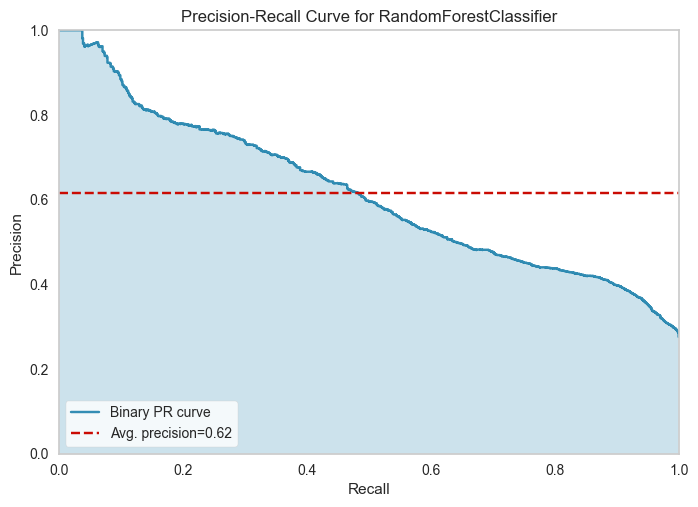

In [356]:
best_model = model_experiment7

plot_model(estimator=best_model, plot='pr')

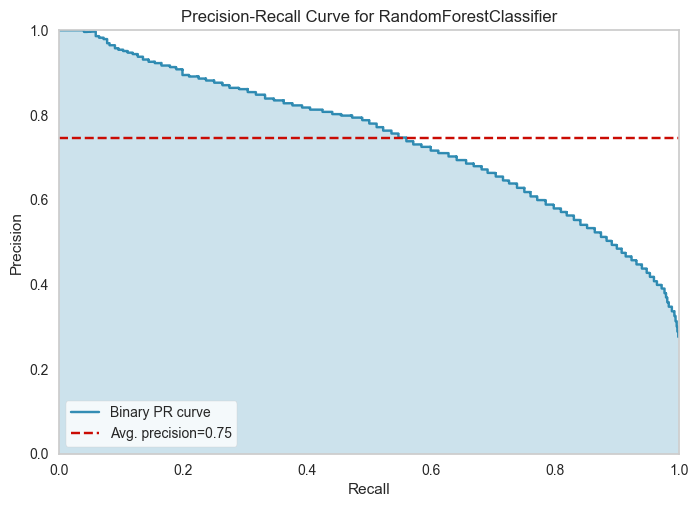

In [357]:
plot_model(estimator=model_experiment0, plot='pr')

Notes:

* roc-auc curve not appropriate?

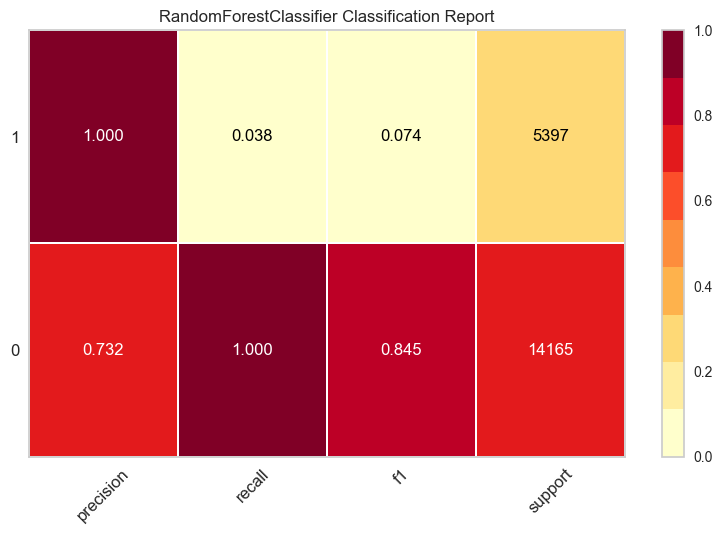

In [359]:
plot_model(estimator=best_model, plot='class_report')

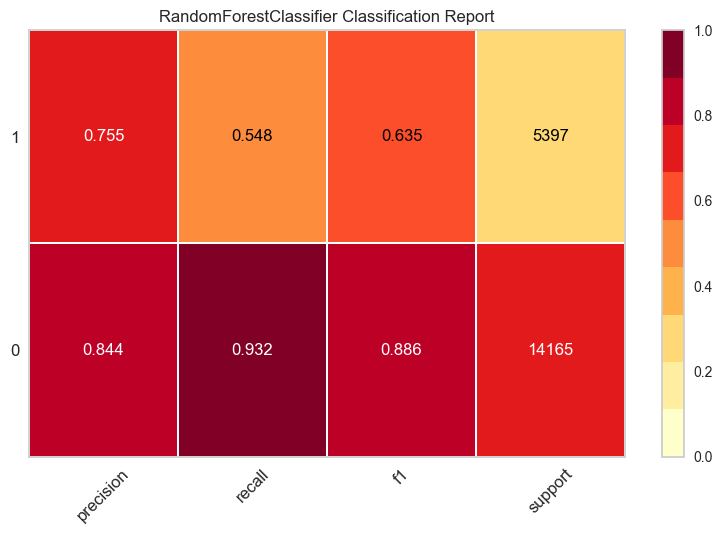

In [360]:
plot_model(estimator=model_experiment0, plot='class_report')

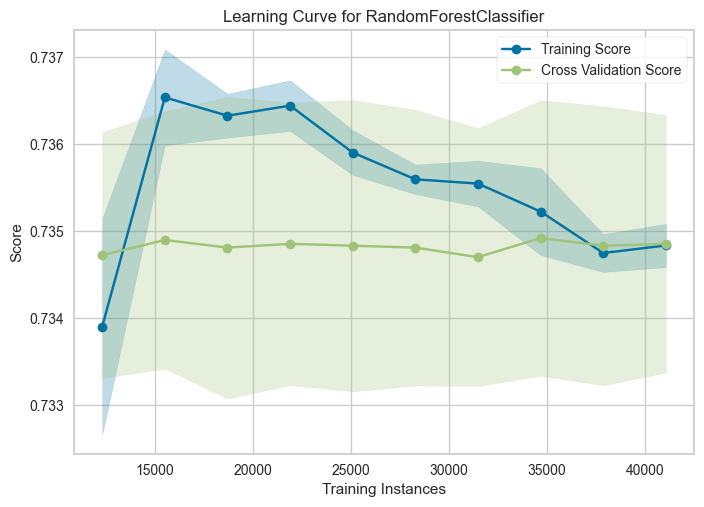

In [368]:
plot_model(estimator=best_model, plot='learning')

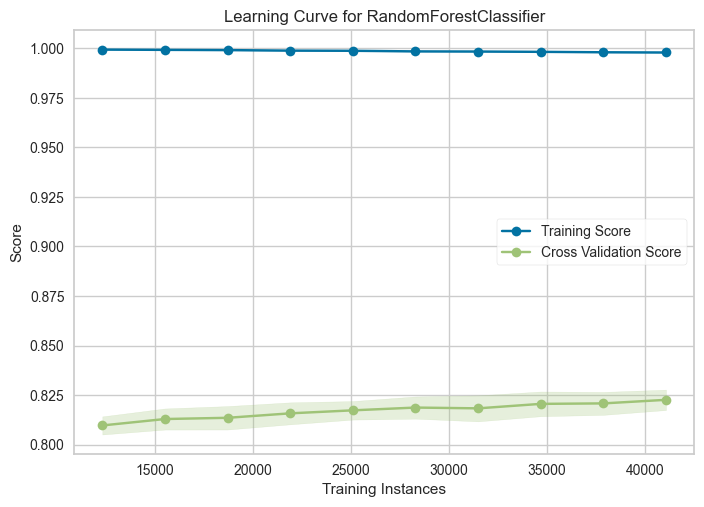

In [367]:
plot_model(estimator=model_experiment0, plot='learning')

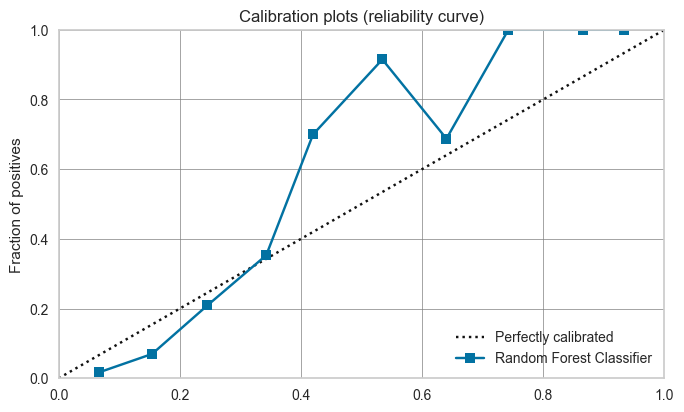

In [369]:
plot_model(estimator=best_model, plot='calibration')

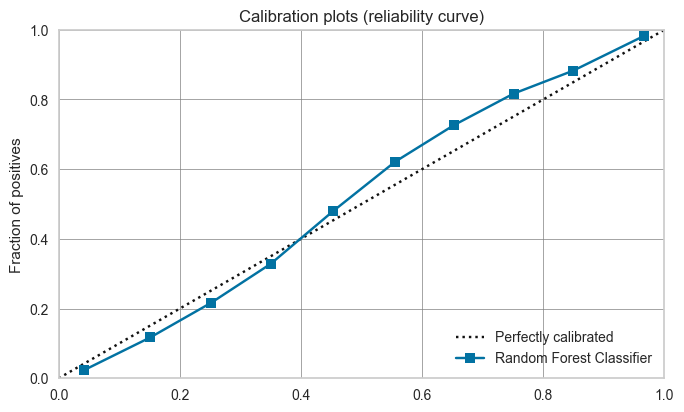

In [370]:
plot_model(estimator=model_experiment0, plot='calibration')

In [373]:
best_model_calibrated = calibrate_model(estimator=best_model, method='isotonic')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,Cost
Fold,,,,,,,,,
0,0.7807,0.8038,0.3825,0.6837,0.4906,0.3648,0.3897,0.5907,203050.0000
1,0.7864,0.8073,0.3897,0.7044,0.5018,0.3799,0.4068,0.6065,196375.0000
2,0.7783,0.7923,0.3627,0.6862,0.4746,0.3506,0.3792,0.5823,203225.0000
3,0.7796,0.7975,0.3542,0.6980,0.4700,0.3491,0.3811,0.5845,200175.0000
4,0.7879,0.7927,0.3693,0.7277,0.4900,0.3736,0.4079,0.6094,191150.0000
5,0.7706,0.7805,0.3638,0.6506,0.4666,0.3351,0.3580,0.5620,213975.0000
6,0.7772,0.7891,0.3844,0.6667,0.4877,0.3581,0.3803,0.5813,208225.0000
7,0.7730,0.7787,0.3662,0.6595,0.4709,0.3411,0.3651,0.5684,211050.0000
8,0.7748,0.7893,0.3685,0.6657,0.4744,0.3458,0.3703,0.5733,209025.0000


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

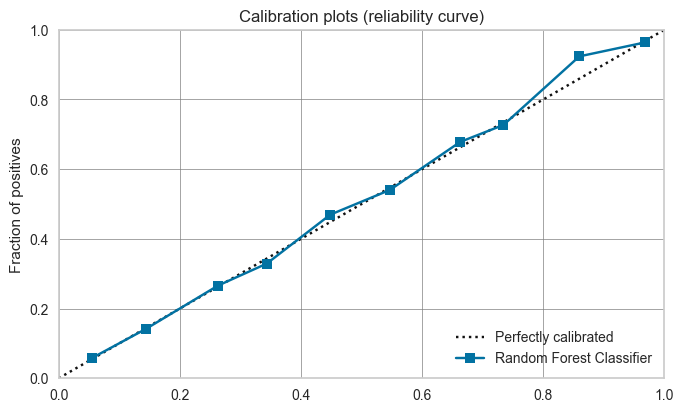

In [374]:
plot_model(estimator=best_model_calibrated, plot='calibration')

In [377]:
import dice_ml

continuous_features_ = [var for var in numeric_vars.drop(columns=['is_canceled', 'arrival_date_week_number', 'total_stays_in_nights', 
                                                                 'total_guests', 'previous_bookings_not_canceled', 'revenue'])]

dice_ml.Data(dataframe=df_train,
             continuous_features=continuous_features_,
             outcome_name=)